In [3]:
import numpy as np
import pandas as pd
import pymc as pm

import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf

import bs4 as bs
import requests
import yfinance as yf
import datetime

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import beta
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF

from copulas.visualization import scatter_2d
from copulas.visualization import dist_1d
from copulas.multivariate import GaussianMultivariate

import tools as tl

# Read the CSV files
data1_cd4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
data1_cd4 = tl.TPM(data1_cd4)
df_0 = data1_cd4[["MT-CO1", "MT-CO2"]]

normalized_gibbs = pd.read_csv("mt-datasets/gibbs_results.csv")
observed = df_0.values
observed_Y = np.array(df_0[["MT-CO2"]])
name_1 = data1_cd4.columns.values[1]

protein_coding_genes = ["MT-CO1", "MT-CO2", "MT-CO3", "MT-CYB", 
                        "MT-ND1", "MT-ND2", "MT-ND3", "MT-ND4", 
                        "MT-ND4L", "MT-ND5", "MT-ND6", "MT-ATP6", 
                        "MT-ATP8"]
normalized_gibbs.columns=protein_coding_genes
df_gib = normalized_gibbs[["MT-CO1", "MT-CO2"]]
df_gib = tl.filter_outliers(df_gib)
name_1 = protein_coding_genes[0]
name_2 = protein_coding_genes[1]

/var/folders/5q/z83yd5r96290nk8203y3gnkr0000gn/T/ipykernel_94932/2381410678.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



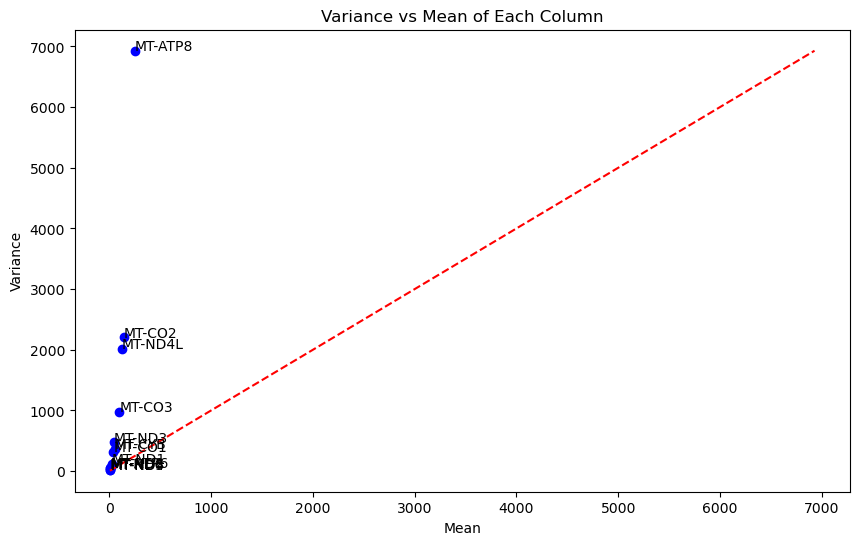

In [18]:
mean_values = data1_cd4.mean()
var_values = data1_cd4.var()

plt.figure(figsize=(10, 6))
plt.scatter(mean_values, var_values, color='blue')

# Annotate each point with the gene name
for i, gene in enumerate(data1_cd4.columns):
    plt.annotate(gene, (mean_values[i], var_values[i]))
min_val = min(min(mean_values), min(var_values))
max_val = max(max(mean_values), max(var_values))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Add titles and labels
plt.title('Variance vs Mean of Each Column')
plt.xlabel('Mean')
plt.ylabel('Variance')

# Show plot
plt.show()

In [23]:
print(var_values)
print(mean_values)

MT-CO1      318.605131
MT-CO2     2210.986586
MT-CO3      978.225497
MT-CYB      367.259849
MT-ND1      120.377049
MT-ND2       63.454191
MT-ND3      479.432694
MT-ND4       24.105833
MT-ND4L    2018.286819
MT-ND5       20.683382
MT-ND6       43.363028
MT-ATP6      57.921726
MT-ATP8    6929.823558
dtype: float64
MT-CO1      36.620352
MT-CO2     139.330403
MT-CO3      95.587461
MT-CYB      51.680725
MT-ND1      22.774419
MT-ND2      12.331193
MT-ND3      42.598595
MT-ND4       6.774915
MT-ND4L    120.650338
MT-ND5       7.831205
MT-ND6       5.365506
MT-ATP6      8.871717
MT-ATP8    250.406905
dtype: float64


In [4]:
df = tl.filter_outliers(df_0)
df_gib = tl.filter_outliers(df_gib)
scatter_2d(df)

In [20]:

dist_1d(data1_cd4['MT-CO3'], title=name_1)


In [111]:
dist_1d(df_gib[name_1], title=name_1)

In [10]:
copula = GaussianMultivariate()
copula.fit(df)
print(df[name_1])

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



0       30.321946
1       56.998655
2       34.060899
3       48.433953
4       11.599400
          ...    
2842    76.569801
2843    35.842777
2844    28.668374
2845    50.678805
2846    24.533582
Name: MT-CO1, Length: 2847, dtype: float64


In [11]:
cdf_1= copula.univariates[0].cdf(df[name_1])
dist_1d(cdf_1, title=name_1)

In [12]:
from copulas.visualization import compare_2d
import seaborn as sns
copula.fit(df)
synthetic = copula.sample(len(df))

copula.fit(df_gib)
synthetic_1 = copula.sample(len(df_gib))

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt



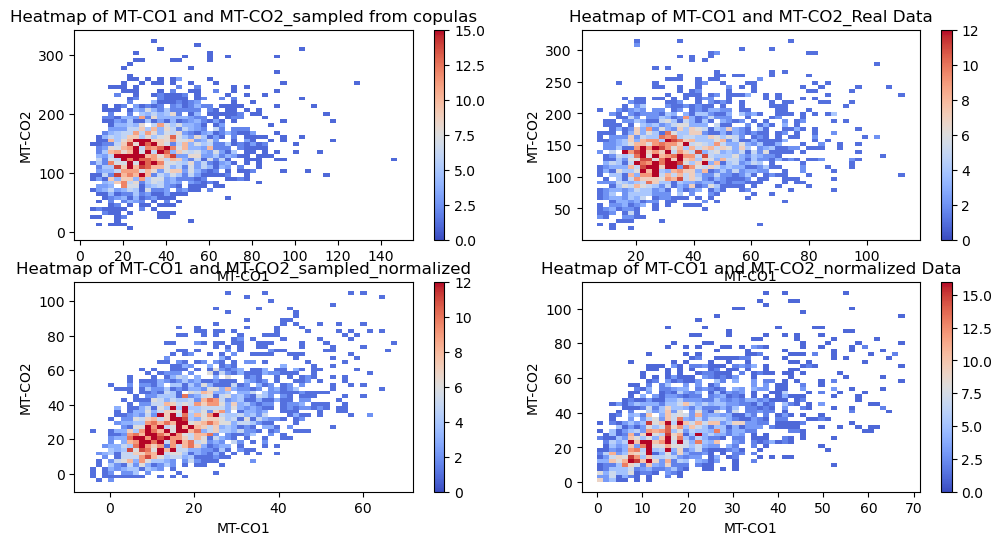

In [13]:

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
heatmap = sns.histplot(data=synthetic, x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_sampled from copulas')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)

plt.subplot(2, 2, 2)
heatmap = sns.histplot(data=tl.filter_outliers(data1_cd4[[name_1,name_2]]), x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_Real Data')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)


plt.subplot(2, 2, 3)
heatmap = sns.histplot(data=synthetic_1, x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_sampled_normalized')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)

plt.subplot(2, 2, 4)
heatmap = sns.histplot(data=tl.filter_outliers(normalized_gibbs[[name_1,name_2]]), x=name_1, y=name_2, bins=50, pmax=0.9, cbar=True, cmap='coolwarm')
heatmap.set_title(f'Heatmap of {name_1} and {name_2}_normalized Data')
heatmap.set_xlabel(name_1)
heatmap.set_ylabel(name_2)

plt.show()

In [14]:
compare_2d(df, synthetic)

In [16]:
compare_2d(df, synthetic_1)

In [118]:
synthetic.corr().iloc[0, 1]

0.529987263107156

In [3]:
cor = tl.get_cor_copulas(data1_cd4[protein_coding_genes], protein_coding_genes)

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/

array([[0.        , 0.56263399, 0.59364464, 0.45953818, 0.41342753,
        0.32887053, 0.41558298, 0.34197841, 0.38876677, 0.36966444,
        0.18911963, 0.28744965, 0.46069505],
       [0.        , 0.        , 0.72232211, 0.72696517, 0.58089986,
        0.50970681, 0.59151923, 0.43218501, 0.69421952, 0.49230158,
        0.25766262, 0.37783862, 0.66624111],
       [0.        , 0.        , 0.        , 0.71309628, 0.64891181,
        0.45769528, 0.58127279, 0.42635413, 0.60572087, 0.51181936,
        0.23493053, 0.32769129, 0.70205853],
       [0.        , 0.        , 0.        , 0.        , 0.62068001,
        0.52152124, 0.5439373 , 0.43858153, 0.67416615, 0.55317112,
        0.2629834 , 0.36852724, 0.67934364],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.49880358, 0.50789425, 0.36523767, 0.59160321, 0.46188628,
        0.26321925, 0.35626564, 0.67051225],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.34994

In [14]:
cor_norm=tl.get_cor_copulas(normalized_gibbs, protein_coding_genes)

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWa

array([[0.        , 0.56611572, 0.5664251 , 0.53652113, 0.43692172,
        0.34761639, 0.43795303, 0.30842495, 0.48185131, 0.47259466,
        0.28257141, 0.31903889, 0.51752131],
       [0.        , 0.        , 0.66650949, 0.62787502, 0.5111962 ,
        0.39720378, 0.42143176, 0.31473988, 0.573197  , 0.4082254 ,
        0.17865883, 0.2709643 , 0.62020509],
       [0.        , 0.        , 0.        , 0.607741  , 0.53222022,
        0.43021093, 0.44320726, 0.37185469, 0.57532   , 0.46258673,
        0.22537326, 0.3423572 , 0.64830711],
       [0.        , 0.        , 0.        , 0.        , 0.54388304,
        0.44249753, 0.44564405, 0.41735482, 0.58386736, 0.50033693,
        0.27426603, 0.36563461, 0.64400557],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.49823043, 0.51959704, 0.41120327, 0.54313619, 0.52510133,
        0.32977999, 0.40881877, 0.58680511],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.47414

In [77]:
cor_o = np.zeros((13,13))
for i in range(13):
    for j in range(i+1,13):
        df_0 = normalized_gibbs[[protein_coding_genes[i], protein_coding_genes[j]]]
        df = tl.filter_outliers(df_0)
        copula.fit(df)
        synthetic = copula.sample(len(df))
        cor_o[i,j]=synthetic.corr().iloc[0, 1]
        print(cor_o[i,j])
print(cor_o)



/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning:

invalid value encountered in sqrt

/opt/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWa

[[0.         0.55784521 0.57909839 0.5436443  0.44367122 0.37533352
  0.44221224 0.33550643 0.4852779  0.4377222  0.25044558 0.30806638
  0.51602893]
 [0.         0.         0.64787413 0.65870057 0.50152234 0.43325383
  0.41144724 0.33519477 0.53318685 0.44802223 0.17621425 0.27009395
  0.62672169]
 [0.         0.         0.         0.63085336 0.5265455  0.44027156
  0.46400561 0.38811397 0.58092036 0.4884362  0.2178663  0.3180743
  0.65378551]
 [0.         0.         0.         0.         0.54536356 0.44457138
  0.48087183 0.35914873 0.59784203 0.48612146 0.27482723 0.35021408
  0.6386107 ]
 [0.         0.         0.         0.         0.         0.47790308
  0.49797367 0.43195477 0.57129018 0.48082382 0.30713886 0.40584733
  0.58956125]
 [0.         0.         0.         0.         0.         0.
  0.48700661 0.4209125  0.48219199 0.49065007 0.30760341 0.37910733
  0.48401905]
 [0.         0.         0.         0.         0.         0.
  0.         0.44630839 0.46135289 0.47272164 0.3

In [13]:
# importing packages 
import scipy.stats as stats 

# no of hours a student studies 
# in a week vs expected no of hours 
observed_data = synthetic
expected_data = df


# Chi-Square Goodness of Fit Test 
chi_square_test_statistic, p_value = stats.chisquare( 
	observed_data, expected_data) 

# chi square test statistic and p value 
print('chi_square_test_statistic is : ' +
	str(chi_square_test_statistic)) 
print('p_value : ' + str(p_value)) 


# find Chi-Square critical value 
print(stats.chi2.ppf(1-0.05, df=6)) 


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
[0.01113224 0.01989384]